In [1]:
%pip install fastai duckduckgo_search 

  Using cached primp-0.9.1-cp38-abi3-macosx_11_0_arm64.whl (2.7 MB)
You should consider upgrading via the '/Users/thislexic/Desktop/me-projects/ai-cookbook/venv/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Data Augmentation

Data augmentation refers to creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data. Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes. For natural photo images, a standard set of augmentations that we have found work pretty well are provided with the aug_transforms function. 

Because our images are now all the same size, we can apply these augmentations to an entire batch of them using the GPU, which will save a lot of time. To tell fastai we want to use these transforms on a batch, we use the batch_tfms parameter

We can also use RandomResizedCrop to get snippets of the image.

### 1. Gathering data

In [2]:
import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1" # needed to fix a bug with running augmentations on Mac

In [3]:
from duckduckgo_search import DDGS 
from fastcore.all import *
from typing import List

def search_images(keywords, max_images=100) -> List[str]:
    """
    returns a list of urls to images
    """
    return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

In [4]:
from fastai.vision.all import *

searches = ['dog chowchow','dog pitbull', 'dog chihuahua', 'dog shih tzu', 'cat']
path = Path('pet')

should_get_images = False
if should_get_images:
    for search_word in searches:
        dest = (path/search_word)
        dest.mkdir(exist_ok=True, parents=True)
        
        download_images(dest, urls=search_images(f'{search_word} photo'))

/Users/thislexic/Desktop/me-projects/ai-cookbook/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
f"{len(failed)} photos are invalid"

'0 photos are invalid'

### 2. Augmenting data

In [20]:
pets = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))
dls = pets.dataloaders(path)

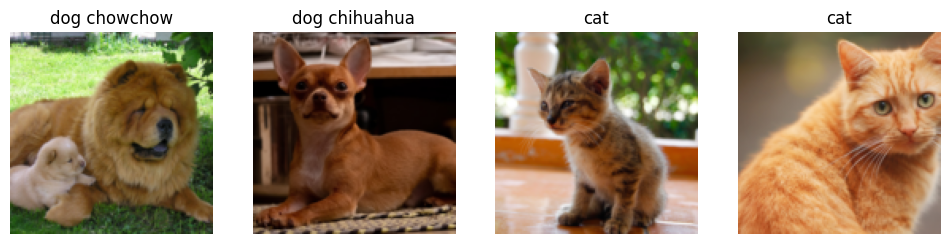

In [7]:
dls.valid.show_batch(max_n=4, nrows=1)

# These are just cropped images

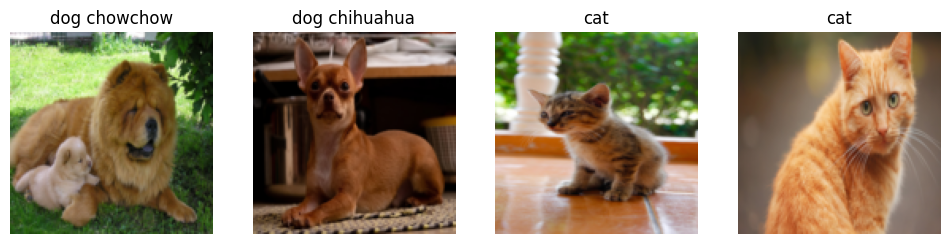

In [8]:
pets = pets.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = pets.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

# These are the same sizes but they are squished. The proportions have changed but we retain some part of the pictures

All of these approaches seem somewhat wasteful, or problematic. If we squish or stretch the images they end up as unrealistic shapes, leading to a model that learns that things look different to how they actually are, which we would expect to result in lower accuracy. If we crop the images then we remove some of the features that allow us to perform recognition. For instance, if we were trying to recognize breeds of dog or cat, we might end up cropping out a key part of the body or the face necessary to distinguish between similar breeds. If we pad the images then we have a whole lot of empty space, which is just wasted computation for our model and results in a lower effective resolution for the part of the image we actually use.

Instead, what we normally do in practice is to randomly select part of the image, and crop to just that part. On each epoch (which is one complete pass through all of our images in the dataset) we randomly select a different part of each image. This means that our model can learn to focus on, and recognize, different features in our images. It also reflects how images work in the real world: different photos of the same thing may be framed in slightly different ways.

In fact, an entirely untrained neural network knows nothing whatsoever about how images behave. It doesn't even recognize that when an object is rotated by one degree, it still is a picture of the same thing! So actually training the neural network with examples of images where the objects are in slightly different places and slightly different sizes helps it to understand the basic concept of what an object is, and how it can be represented in an image.

Here's another example where we replace Resize with RandomResizedCrop, which is the transform that provides the behavior we just described. The most important parameter to pass in is min_scale, which determines how much of the image to select at minimum each time:

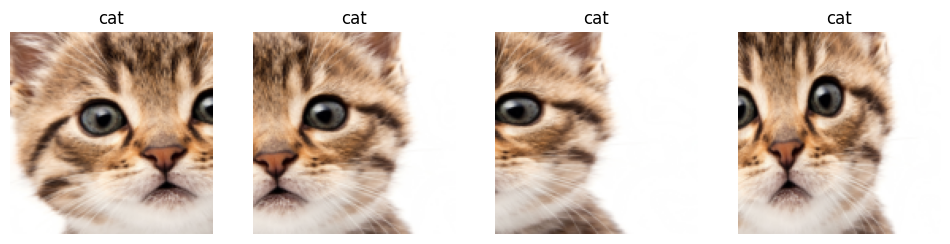

In [9]:
pets = pets.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = pets.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

/Users/thislexic/Desktop/me-projects/ai-cookbook/venv/lib/python3.9/site-packages/torch/_tensor.py:1512: UserWarning: The operator 'aten::_linalg_solve_ex.result' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  ret = func(*args, **kwargs)


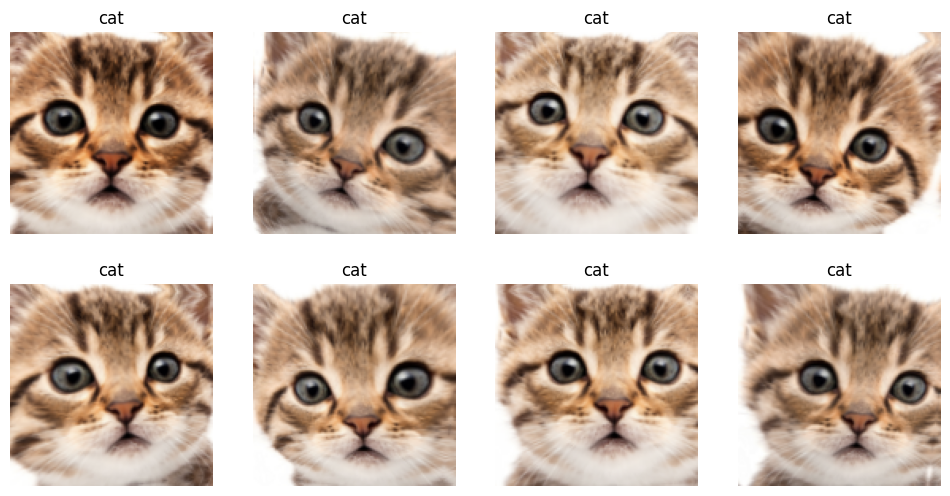

In [10]:
pets = pets.new(item_tfms=Resize(128), batch_tfms=aug_transforms())
dls = pets.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

# even more kinds of augmentations

Using data augmentations allow us to run lots of epochs (>10) with each epoch having slightly different pictures which make our model better.

Note that data augmentations do not create copies of the image in storage. Instead, in each epoch, the model goes through all of the images. In each epoch, each image is augmented in memory. 

To the model, it just looks like we have an infinite variety of slightly different pictures since that is all the model sees.

### 3. Training the model then using it to Clean the data

In [21]:
from fastai.vision.all import *

pets = pets.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = pets.dataloaders(path)

In [22]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.220942,0.020267,0.016807,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.058046,0.005032,0.000000,00:33
1,0.036678,0.008802,0.004202,00:32
2,0.028038,0.006010,0.004202,00:33
3,0.019897,0.006365,0.004202,00:32


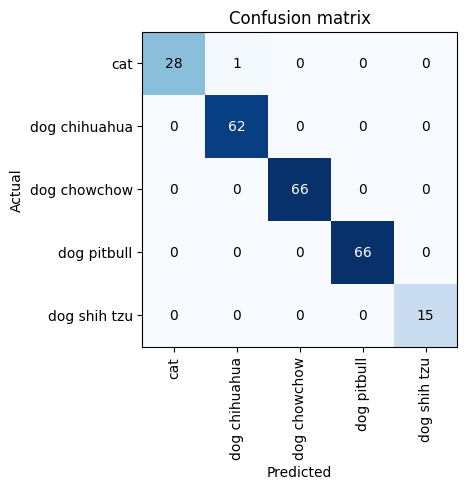

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Plot out where your model is getting confused

The diagonal of the matrix shows the images which were classified correctly, and the off-diagonal cells represent those which were classified incorrectly. This is one of the many ways that fastai allows you to view the results of your model. It is (of course!) calculated using the validation set. With the color-coding, the goal is to have white everywhere except the diagonal, where we want dark blue.

It's helpful to see where exactly our errors are occurring, to see whether they're due to a dataset problem (e.g., images that aren't pets at all, or are labeled incorrectly, etc.), or a model problem (perhaps it isn't handling images taken with unusual lighting, or from a different angle, etc.). To do this, we can sort our images by their loss.

The loss is a number that is higher if the model is incorrect (especially if it's also confident of its incorrect answer), or if it's correct, but not confident of its correct answer. In a couple of chapters we'll learn in depth how loss is calculated and used in the training process. For now, plot_top_losses shows us the images with the highest loss in our dataset. As the title of the output says, each image is labeled with four things: prediction, actual (target label), loss, and probability. The probability here is the confidence level, from zero to one, that the model has assigned to its prediction:

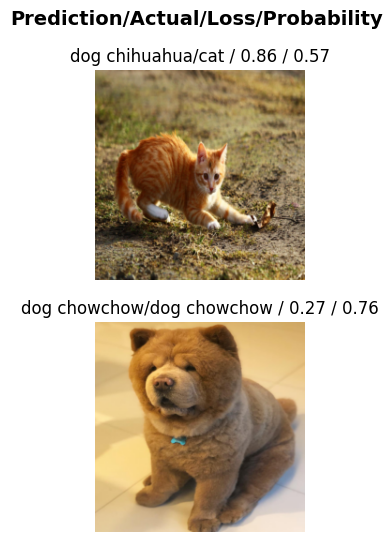

In [24]:
interp.plot_top_losses(2, nrows=2)

This output shows that the image with the highest loss is one that has been predicted as "pitbull" with high confidence. However, it's labeled (based on our Bing image search) as "pitbull." We're not dog experts, but it sure looks to us like this label is incorrect! We should probably change its label to "pitbull."

The intuitive approach to doing data cleaning is to do it before you train a model. But as you've seen in this case, a model can actually help you find data issues more quickly and easily. So, we normally prefer to train a quick and simple model first, and then use it to help us with data cleaning.

fastai includes a handy GUI for data cleaning called ImageClassifierCleaner that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling:

In [25]:
from fastai.vision.widgets import ImageClassifierCleaner

cleaner = ImageClassifierCleaner(learn)
cleaner

In [18]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

ImageClassifierCleaner doesn't actually do the deleting or changing of labels for you; it just returns the indices of items to change. So, for instance, to delete (unlink) all images selected for deletion, we would run:

```
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
```

To move images for which we've selected a different category, we would run:

```
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)
```

Cleaning the data and getting it ready for your model are two of the biggest challenges for data scientists; they say it takes 90% of their time. The fastai library aims to provide tools that make it as easy as possible.

This technique of training the model first before cleaning the data is not only applicable to image recognition. Always build a model first before cleaning your data so that you can:
1. identify which things are difficult to recognize in your data
2. let the model help you find data problems

Once we've cleaned up our data, we can retrain our model. Try it yourself, and see if your accuracy improves!

Now that we have trained our model, let's see how we can deploy it to be used in practice.